In [5]:
import re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict 

Saved: /home/alapena/GitHub/graph2mat4abn/results_convergence_test/0888-cde8-4bbf-8840-bbd0accf1d6c_dos_convergence.png


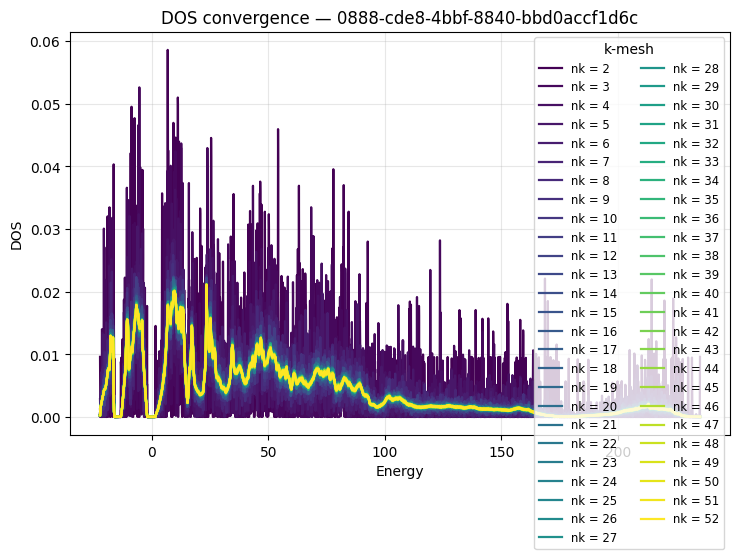

In [6]:
savedir = Path("/home/alapena/GitHub/graph2mat4abn/results_convergence_test")

# Pattern: {structure}_dos_mesh{nk}.npz
fname_re = re.compile(r"^(?P<structure>.+)_dos_mesh(?P<nk>\d+)\.npz$")

# Collect files
files = []
for p in sorted(savedir.glob("*.npz")):
    m = fname_re.match(p.name)
    if m:
        structure = m.group("structure")
        nk = int(m.group("nk"))
        files.append((structure, nk, p))

if not files:
    raise SystemExit(f"No matching files found in {savedir}")

# Group by structure
groups = defaultdict(list)
for structure, nk, p in files:
    groups[structure].append((nk, p))

for structure, items in groups.items():
    # Sort by nk
    items.sort(key=lambda x: x[0])

    # Load all and check energies consistency
    loaded = []
    energies_ref = None
    for nk, path in items:
        data = np.load(path, allow_pickle=False)
        energies = data["energies"]
        dos = data["dos"]
        loaded.append((nk, energies, dos, path))

        if energies_ref is None:
            energies_ref = energies
        else:
            if energies.shape != energies_ref.shape or not np.allclose(energies, energies_ref):
                print(f"[warn] Energies differ for {path.name}. Plotting as-is, but legends may not be directly comparable.")
    
    # Plot
    plt.figure(figsize=(7.5, 5.5))
    # Use a colormap for distinct colors
    cmap = plt.get_cmap("viridis")
    N = max(1, len(loaded))

    for i, (nk, energies, dos, path) in enumerate(loaded):
        color = cmap(i / max(1, N - 1))
        plt.plot(energies, dos, label=f"nk = {nk}", lw=1.6, color=color)

    plt.title(f"DOS convergence — {structure}")
    plt.xlabel("Energy")
    plt.ylabel("DOS")
    plt.grid(True, alpha=0.3)
    plt.legend(title="k-mesh", ncol=2, fontsize="small")
    plt.tight_layout()
    # Save alongside data and also show
    outpath = savedir / f"{structure}_dos_convergence.png"
    plt.savefig(outpath, dpi=200)
    print(f"Saved: {outpath}")

plt.show()